In [4]:
import numpy as np
import os
dtype = np.float32

import torch
import torch.nn as nn
import torchvision
from tqdm import tqdm
import os

from transformers import CLIPVisionModelWithProjection, AutoModelForCausalLM
from transformers import AutoModel, AutoTokenizer, OPTForCausalLM, BloomForCausalLM
import numpy

from huggingface_hub import try_to_load_from_cache, _CACHED_NO_EXIST
from huggingface_hub import scan_cache_dir

import glob
import random
import json
import os
import matplotlib.pyplot as plt
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

def get_named_linears(module):
    return {name: m for name, m in module.named_modules() if isinstance(m, nn.Linear)}

def get_blocks(model):
    if model.__class__.__name__ in ("LlamaForCausalLM", "Qwen2ForCausalLM"):
        layers = model.model.layers
    elif model.__class__.__name__ == "LlavaLlamaForCausalLM":
        layers = model.model.layers
    elif isinstance(model, OPTForCausalLM):
        layers = model.model.decoder.layers
    elif isinstance(model, BloomForCausalLM):
        layers = model.transformer.h
    elif "mpt" in str(model.__class__).lower():
        layers = model.transformer.blocks
    elif "falcon" in str(model.__class__).lower():
        layers = model.transformer.h
    elif "bigcode" in str(model.__class__).lower():
        layers = model.transformer.h
    elif "neox" in str(model.__class__).lower():
        layers = model.gpt_neox.layers
    elif model.__class__.__name__ == "LlavaLlamaModel":
        layers = model.llm.model.layers
    else:
        raise NotImplementedError(type(model))
    return layers

In [ ]:
model_list = [
    # 'meta-llama/Meta-Llama-3-8B',
    'meta-llama--Llama-2-7b-hf',
    # 'meta-llama--Llama-2-13b-hf',
]

for model_name in model_list:
    
    model_name = model_name.replace('/', '--')
    print('model_name: ', model_name)
    
    model_path = f"../Wparam_dataset/hf_model/{model_name}"

    model = AutoModelForCausalLM.from_pretrained(model_path, local_files_only=True)
    layers = get_blocks(model)

    for i in tqdm(range(len(layers))):
        named_linears = get_named_linears(layers[i])
        for n, m in named_linears.items():
            W = m.weight.data.detach()
            
            fig = plt.figure(figsize=(6, 4))
            ax = fig.add_subplot(111)
            dist_weight = {}
            for w in W.flatten():
                rounded_weight = round(w.item(), 3)

                # if (rounded_weight > -0.1) and(rounded_weight < 0.1):
                if True:
                    if rounded_weight not in dist_weight:
                        dist_weight[rounded_weight] = 1
                    else:
                        dist_weight[rounded_weight] += 1

            sorted_dist_weight = dict(sorted(dist_weight.items()))
            ax.plot(sorted_dist_weight.keys(), sorted_dist_weight.values(), alpha= 0.5)
            plt.show


model_name:  meta-llama--Llama-2-7b-hf


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

In [4]:
# cache_path = "/home/jgryu/Weight_compression/model_zoo/huggingface/"
# model_name =  "meta-llama/Llama-2-7b-chat-hf"
# # model_name =  "google--codegemma-1.1-7b-it"

# filepath = latest_version_path(cache_path, model_name)
# model = AutoModelForCausalLM.from_pretrained(filepath, local_files_only=True)
# # init_model = AutoModelForCausalLM.from_config(model.config)

In [5]:
# cache_path = "/home/jgryu/Weight_compression/model_zoo/huggingface/"
# model_name =  "meta-llama/Llama-2-7b-hf"

# filepath = latest_version_path(cache_path, model_name)
# model = AutoModelForCausalLM.from_pretrained(filepath, local_files_only=True)
# init_model = AutoModelForCausalLM.from_config(model.config)

# model_only = model_name.split("/")[-1]
# keys = model.model.layers[0].state_dict().keys()

# for k in keys:
#     if "attn" not in k.lower() and "mlp" not in k.lower():
#         continue
    
#     fig, ax = plt.subplots(figsize=(15, 6))
#     ax.set_title(f"{model_only}::{k}")
#     ax.set_xlabel('value')
#     ax.set_ylabel('frequency')

#     for idx, layer in enumerate(model.model.layers):
#         # if idx == 0:        
#         #     v = init_model.model.layers[idx].state_dict()[k]
#         #     print(f"[init]{k}: {v.shape}")

#         #     dist_weight = {}
#         #     for weight in v.flatten():
#         #         rounded_weight = round(weight.item(), 3)

#         #         if (rounded_weight > -0.1) and(rounded_weight < 0.1):
#         #         # if True:
#         #             if rounded_weight not in dist_weight:
#         #                 dist_weight[rounded_weight] = 1
#         #             else:
#         #                 dist_weight[rounded_weight] += 1

#         #     sorted_dist_weight = dict(sorted(dist_weight.items()))
#         #     ax.plot(sorted_dist_weight.keys(), sorted_dist_weight.values(), label=f"initial", alpha= 0.5)
            
#         # if idx >= 3 and  idx % 10 != 1:
#         if idx >= 1:
#             continue

#         v = layer.state_dict()[k]

#         print(f"layer {idx}")
#         print(f"{k}: {v.shape}")

#         dist_weight = {}
#         for weight in v.flatten():
#             rounded_weight = round(weight.item(), 4)

#             if (rounded_weight > -0.1) and(rounded_weight < 0.1):
#             # if True:
#                 if rounded_weight not in dist_weight:
#                     dist_weight[rounded_weight] = 1
#                 else:
#                     dist_weight[rounded_weight] += 1

#         sorted_dist_weight = dict(sorted(dist_weight.items()))

#         ax.plot(sorted_dist_weight.keys(), sorted_dist_weight.values(), label=f"layer.{idx}", alpha= 0.5)
        
#     ax.grid()
#     ax.legend(fancybox=True, shadow=True, ncol=4, loc='upper center', bbox_to_anchor=(0.5, 1.25))
#     path = os.path.join('/home/jgryu/Weight_compression/plots/weight_dist', model_only)
#     os.makedirs(path, exist_ok=True)
#     k = k.replace('.', '_')
#     plt.savefig(os.path.join(path, f'{k}_test.png'),  bbox_inches='tight')
#     plt.show()


Loading checkpoint shards: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]


26
[init]self_attn.q_proj.weight: torch.Size([2048, 2304])
<class 'type'>
std:: 0.02000129222869873
layer 0
self_attn.q_proj.weight: torch.Size([2048, 2304])
std:: 0.011722919531166553
layer 1
self_attn.q_proj.weight: torch.Size([2048, 2304])
std:: 0.011470680125057697
layer 2
self_attn.q_proj.weight: torch.Size([2048, 2304])
std:: 0.012281314469873905
layer 11
self_attn.q_proj.weight: torch.Size([2048, 2304])
std:: 0.012111632153391838
layer 21
self_attn.q_proj.weight: torch.Size([2048, 2304])
std:: 0.011697662994265556
[init]self_attn.k_proj.weight: torch.Size([1024, 2304])
<class 'type'>
std:: 0.020007535815238953
layer 0
self_attn.k_proj.weight: torch.Size([1024, 2304])
std:: 0.012156209908425808
layer 1
self_attn.k_proj.weight: torch.Size([1024, 2304])
std:: 0.011857163161039352
layer 2
self_attn.k_proj.weight: torch.Size([1024, 2304])
std:: 0.012562444433569908
layer 11
self_attn.k_proj.weight: torch.Size([1024, 2304])
std:: 0.012249327264726162
layer 21
self_attn.k_proj.weight: 

Loading checkpoint shards: 100%|██████████| 8/8 [00:14<00:00,  1.76s/it]


42
[init]self_attn.q_proj.weight: torch.Size([4096, 3584])
<class 'type'>
std:: 0.01999545469880104
layer 0
self_attn.q_proj.weight: torch.Size([4096, 3584])
std:: 0.006672493647783995
layer 1
self_attn.q_proj.weight: torch.Size([4096, 3584])
std:: 0.007267693988978863
layer 2
self_attn.q_proj.weight: torch.Size([4096, 3584])
std:: 0.007395981810986996
layer 11
self_attn.q_proj.weight: torch.Size([4096, 3584])
std:: 0.006731260102242231
layer 21
self_attn.q_proj.weight: torch.Size([4096, 3584])
std:: 0.007539546117186546
layer 31
self_attn.q_proj.weight: torch.Size([4096, 3584])
std:: 0.008210951462388039
layer 41
self_attn.q_proj.weight: torch.Size([4096, 3584])
std:: 0.00860974844545126
[init]self_attn.k_proj.weight: torch.Size([2048, 3584])
<class 'type'>
std:: 0.019996680319309235
layer 0
self_attn.k_proj.weight: torch.Size([2048, 3584])
std:: 0.006615808699280024
layer 1
self_attn.k_proj.weight: torch.Size([2048, 3584])
std:: 0.0073527186177670956
layer 2
self_attn.k_proj.weight: 

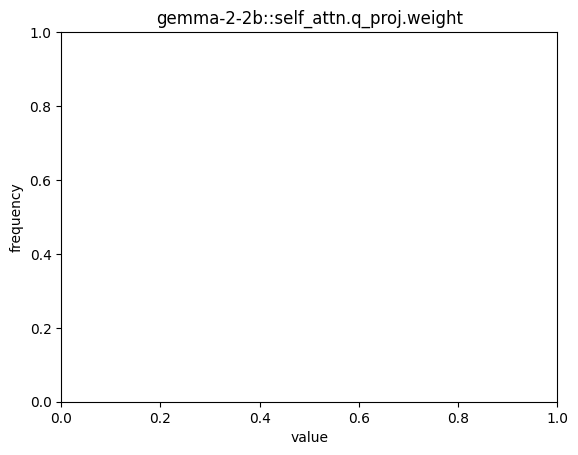

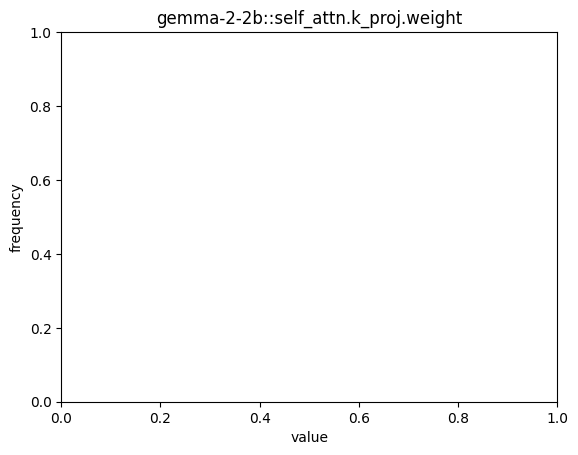

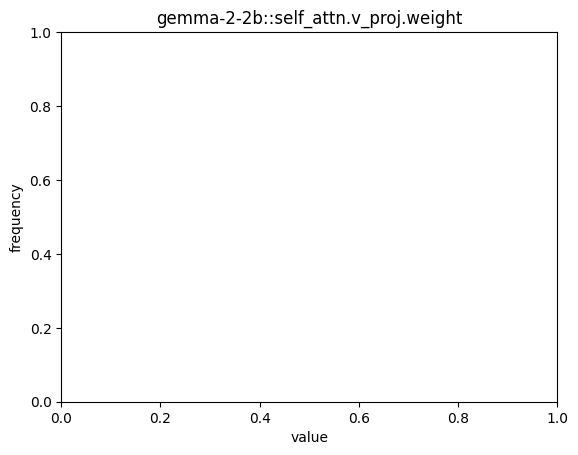

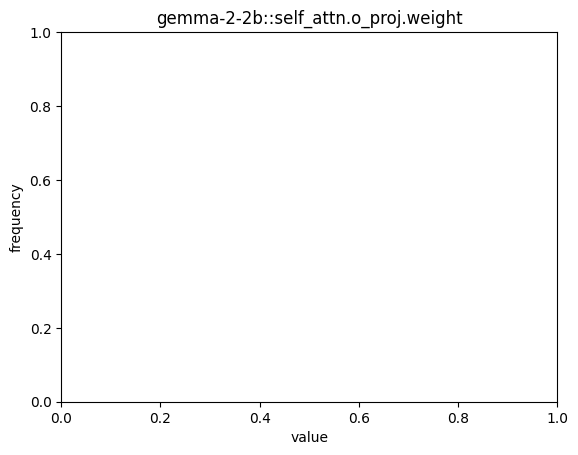

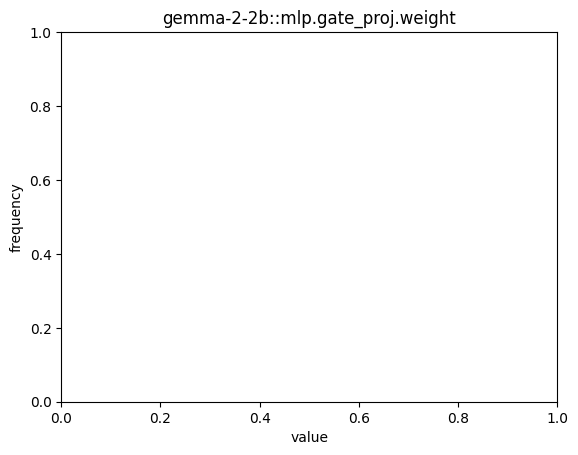

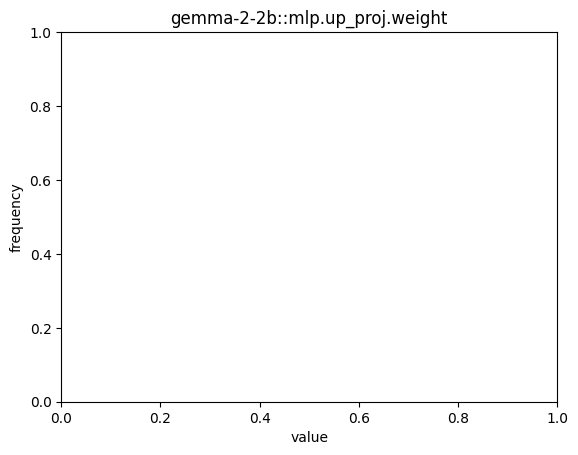

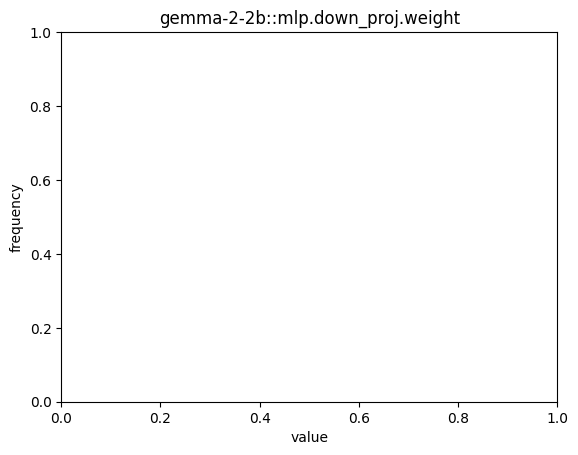

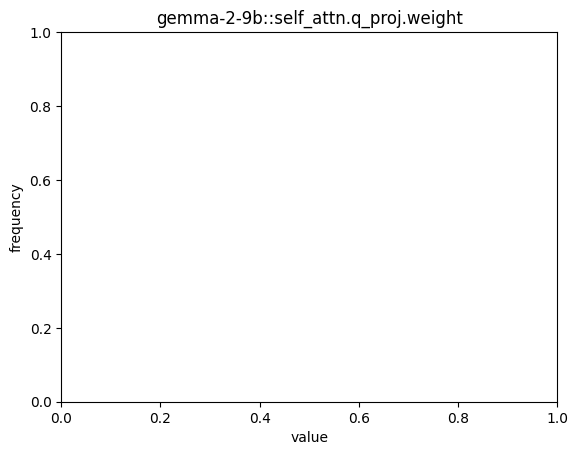

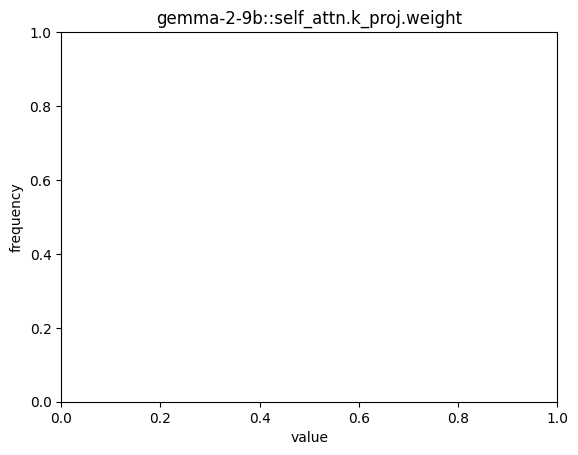

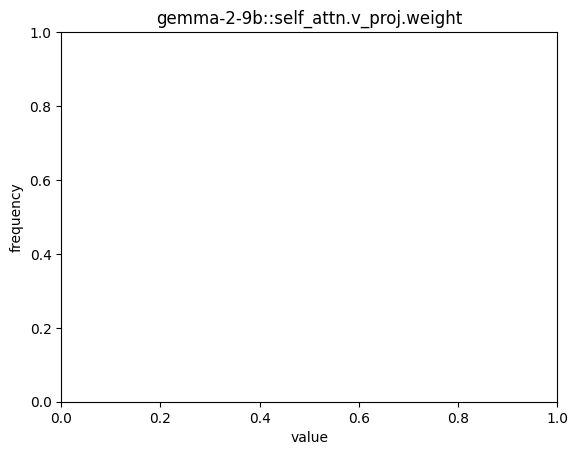

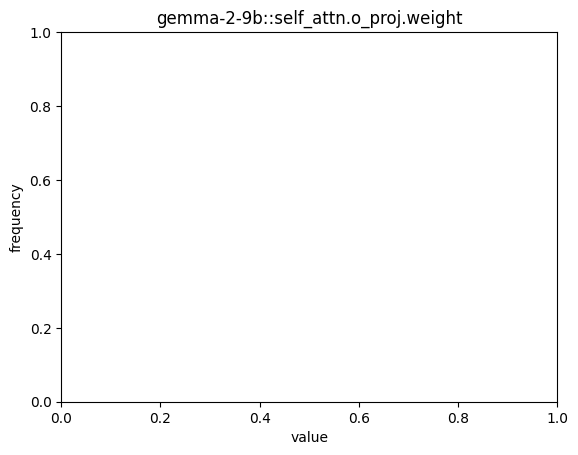

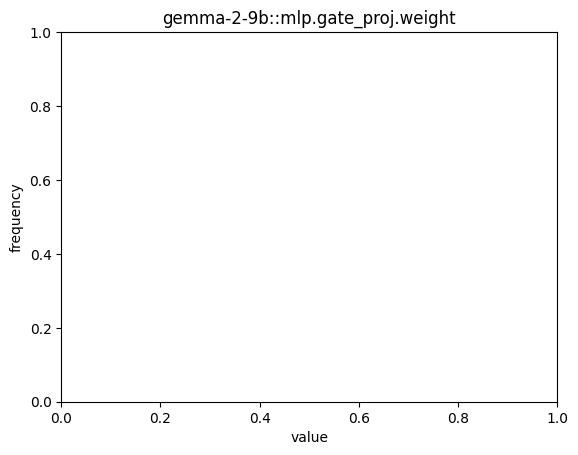

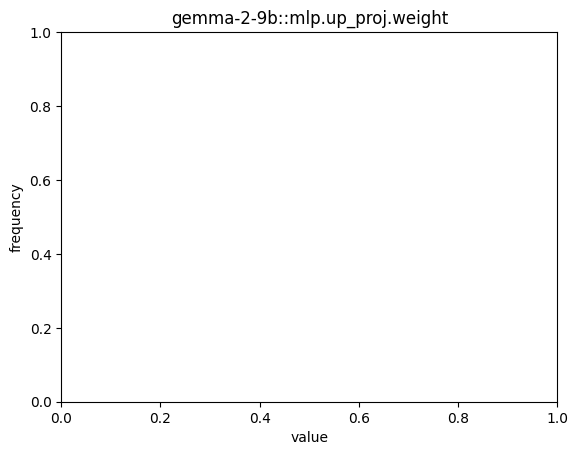

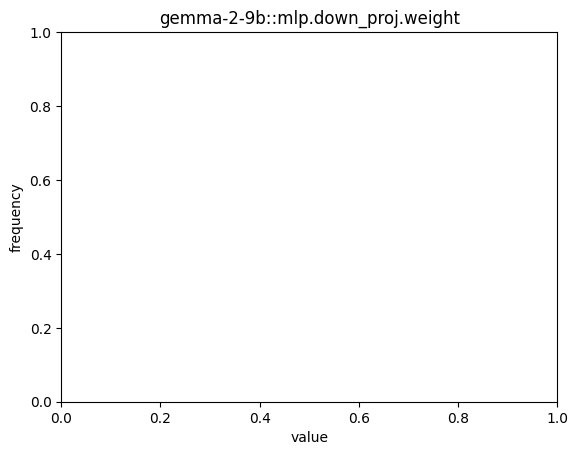

In [9]:
cache_path = "/home/jgryu/Weight_compression/model_zoo/huggingface/"
model_name_list =  ["google/gemma-2-2b", "google/gemma-2-9b"]

for model_name in model_name_list:
    filepath = latest_version_path(cache_path, model_name)
    model = AutoModelForCausalLM.from_pretrained(filepath, local_files_only=True)
    init_model = AutoModelForCausalLM.from_config(model.config)

    print(len(model.model.layers))
    model_only = model_name.split("/")[-1]
    keys = model.model.layers[0].state_dict().keys()

    for k in keys:
        if "attn" not in k.lower() and "mlp" not in k.lower():
            continue
        
        fig, ax = plt.subplots()
        ax.set_title(f"{model_only}::{k}")
        ax.set_xlabel('value')
        ax.set_ylabel('frequency')

        for idx, layer in enumerate(model.model.layers):
            if idx == 0:        
                v = init_model.model.layers[idx].state_dict()[k]
                print(f"[init]{k}: {v.shape}")
                print(f'std:: {np.std(v.numpy())}')
                # dist_weight = {}
                # for weight in v.flatten():
                #     rounded_weight = round(weight.item(), 3)

                #     if (rounded_weight > -0.1) and(rounded_weight < 0.1):
                #     # if True:
                #         if rounded_weight not in dist_weight:
                #             dist_weight[rounded_weight] = 1
                #         else:
                #             dist_weight[rounded_weight] += 1

                # sorted_dist_weight = dict(sorted(dist_weight.items()))
                # ax.plot(sorted_dist_weight.keys(), sorted_dist_weight.values(), label=f"initial", alpha= 0.5)
                
            if idx >= 3 and idx% 10 != 1:
                continue

            v = layer.state_dict()[k]

            print(f"layer {idx}")
            print(f"{k}: {v.shape}")
            print(f'std:: {np.std(v.numpy())}')
            
            # dist_weight = {}
            # for weight in v.flatten():
            #     rounded_weight = round(weight.item(), 3)

            #     if (rounded_weight > -0.1) and(rounded_weight < 0.1):
            #     # if True:
            #         if rounded_weight not in dist_weight:
            #             dist_weight[rounded_weight] = 1
            #         else:
            #             dist_weight[rounded_weight] += 1

            # sorted_dist_weight = dict(sorted(dist_weight.items()))

            # ax.plot(sorted_dist_weight.keys(), sorted_dist_weight.values(), label=f"layer.{idx}", alpha= 0.5)
            
        # ax.grid()
        # ax.legend(fancybox=True, shadow=True, ncol=4, loc='upper center', bbox_to_anchor=(0.5, 1.25))
        # path = os.path.join('/home/jgryu/Weight_compression/plots/weight_dist', model_only)
        # os.makedirs(path, exist_ok=True)
        # k = k.replace('.', '_')
        # plt.savefig(os.path.join(path, f'{k}.png'),  bbox_inches='tight')
        # plt.show()

In [8]:
type(v.numpy())

numpy.ndarray